In [1]:
import os
import nibabel as nib
import cv2 as cv
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

slices_excluir = "/home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/text-info-files/excluir-slices.txt"

t2flair_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/T2flair-study"
t1w_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/T1w-study"
roi_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/roi"

t2flair_nii_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/T2flair-study-nii"
t1w_nii_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/T1w-study-nii"
roi_nii_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/roi-nii"

t2flair_im_train_path = "/home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/train"
t2flair_im_val_path = "/home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/val"
t2flair_label_train_path = "/home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/train"
t2flair_label_train_val = "/home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/val"

t1w_im_train_path = "/home/mariopasc/Python/Datasets/t1w-yolov8-ds/images/train"
t1w_im_val_path = "/home/mariopasc/Python/Datasets/t1w-yolov8-ds/images/val"
t1w_label_train_path = "/home/mariopasc/Python/Datasets/t1w-yolov8-ds/labels/train"
t1w_label_train_val = "/home/mariopasc/Python/Datasets/t1w-yolov8-ds/labels/val"

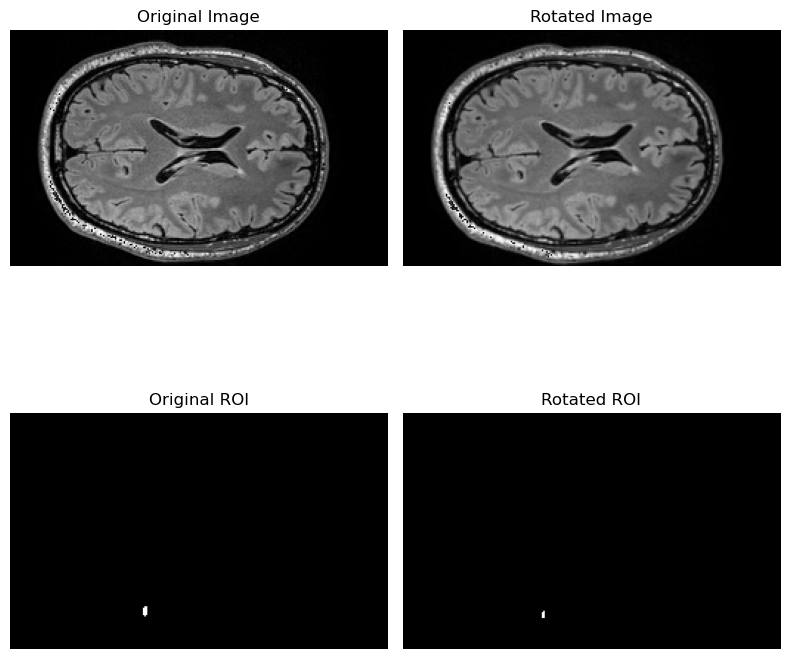

Contorno original: 6 
Contorno rotado: 4
[[91.         21.83333333]
 [90.         22.        ]
 [90.         22.66666667]
 [91.         22.83333333]
 [92.         22.66666667]
 [92.         21.83333333]]


In [100]:
file_original = "sub-00003-147.nii"
file_rotated = "sub-00003-147-rotation-1.nii"

original_im = np.uint8(nib.load(os.path.join(t2flair_nii_path, file_original)).get_fdata())
rotated_im = np.uint8(nib.load(os.path.join(t2flair_nii_path, file_rotated)).get_fdata())
original_roi = np.uint8(nib.load(os.path.join(roi_nii_path, file_original)).get_fdata())
rotated_roi = np.uint8(nib.load(os.path.join(roi_nii_path, file_rotated)).get_fdata())

fig, axes = plt.subplots(2, 2, figsize=(8,9))
axes[0, 0].imshow(original_im, cmap="gray")
axes[0, 0].axis('off')
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(original_roi, cmap="gray")
axes[1, 0].axis('off')
axes[1, 0].set_title("Original ROI")

axes[0, 1].imshow(rotated_im, cmap="gray")
axes[0, 1].axis('off')
axes[0, 1].set_title("Rotated Image")
axes[1, 1].imshow(rotated_roi, cmap="gray")
axes[1, 1].axis('off')
axes[1, 1].set_title("Rotated ROI")

plt.tight_layout()
plt.show()

contours_original, _ = cv.findContours(original_roi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_rotated, _ = cv.findContours(rotated_roi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
normalized = contours_original[0].squeeze().astype('float') / np.array([contours_original[0].shape[1], contours_original[0].shape[0]])
print(f"Contorno original: {len(contours_original[0])} \nContorno rotado: {len(contours_rotated[0])}")
print(normalized)

In [98]:
import math
print(contours_original)
if len(contours_original) > 0:  # There are contours in the ROI
    if math.ceil(len(contours_original[0]) / 2) >= 3: # There are at least 3 tuples <x, y> in the ROI
        print(contours_original[0])

(array([[[133,  48]],

       [[132,  49]],

       [[132,  50]],

       [[131,  51]],

       [[131,  52]],

       [[133,  52]]], dtype=int32),)
[[[133  48]]

 [[132  49]]

 [[132  50]]

 [[131  51]]

 [[131  52]]

 [[133  52]]]


### Data Loader - Convertir .nii.gz a imágenes PNG o JPEG2000

Workflow actual: 

1. Convertir el estudio dado a .nii. La carpeta del estudio dado debe tener en su interior carpetas con el nombre del paciente "sub-00XXXX" y, dentro de esas carpetas, debe estar el archivo .nii.gz. Se puede dar como argumento un .txt con rodajas que se excluirán de convertir a .nii. 
2. Realizar el hold-out de los datos. Los archivos .nii dedicados a train, val y test serán guardados en 3 archivos .txt. Estos archivos serán recibidos como entrada en la función que convierte los archivos .nii a PNG (paso 3) y las redirigirá a sus respectivas carpetas. 
3. Convertir el estudio en .nii a un formato sin pérdidas. Se ha implementado una normalización provisional dentro de este método. En un futuro, cuando se aplique un preprocesamiento a las rodajas del archivo .nii.gz, esta normalización ya vendrá dada. 

**Detalles**

- La función que se encarga de convertir las imágenes a PNG y moverlas a los directorios de train/val/test especificados por el holdout recibe como entrada un archivo .txt con los detalles de todos los paths donde puede encontrar la información. Este txt debe tener un formato como:
```bash
niiFolder: /home/mariopasc/Python/Datasets/ds-epilepsy/T2flair-study-nii
trainFolder: /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/train
trainNiiFiles: /home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/text-info-files/t2flair-study/holdout/train_files.txt
valFolder: /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/val
valNiiFIles: /home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/text-info-files/t2flair-study/holdout/val_files.txt
testFolder: /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/test
testNiiFiles: /home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/text-info-files/t2flair-study/holdout/test_files.txt
format: PNG
```

In [2]:
from ultralytics import YOLO
yaml = "/home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/info-files/t2flair-study/config.yaml"
model = YOLO(model = "yolov8n-seg.pt",
             task='segment')
results_train = model.train(data=yaml, epochs=2, imgsz=640, project="a" ,
                                         save=True, save_period=1,
                                         name="Yolov8-Train", verbose=True,
                                         seed=42, single_cls=True, plots=False,
                                         augment=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, degrees=0.0, translate=0.0,
                                         scale=0.0, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.0, mosaic=0.0,
                                         close_mosaic=0, mixup=0.0, copy_paste=0.0, auto_augment="", erasing=0.0, val=False)
results_val = model.val(data=yaml, imgsz=640, conf=0.001, plots=True, save_json=True)

100%|██████████| 6.73M/6.73M [00:00<00:00, 7.07MB/s]


New https://pypi.org/project/ultralytics/8.1.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.25 🚀 Python-3.8.18 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/info-files/t2flair-study/config.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=a, name=Yolov8-Train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visua

100%|██████████| 6.23M/6.23M [00:00<00:00, 7.04MB/s]
/home/mariopasc/Python/miniconda3/envs/torch_env/lib/python3.8/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/train... 2692 images, 3741 backgrounds, 0 corrupt: 100%|██████████| 6433/6433 [00:01<00:00, 4190.22it/s]


train: New cache created: /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/train.cache


val: Scanning /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/val... 1374 images, 1842 backgrounds, 0 corrupt: 100%|██████████| 3216/3216 [00:00<00:00, 3763.54it/s]

val: New cache created: /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to a/Yolov8-Train
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/2      2.76G      2.339      3.675      9.086      1.554          1        640: 100%|██████████| 403/403 [00:53<00:00,  7.56it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/2      2.66G      1.666      2.503      2.758      1.197          0        640: 100%|██████████| 403/403 [00:51<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:09<00:00, 11.20it/s]

                   all       3216       1556      0.655      0.374      0.411      0.239      0.651      0.364      0.402       0.19



2 epochs completed in 0.032 hours.
Optimizer stripped from a/Yolov8-Train/weights/last.pt, 6.8MB
Optimizer stripped from a/Yolov8-Train/weights/best.pt, 6.8MB

Validating a/Yolov8-Train/weights/best.pt...
Ultralytics YOLOv8.1.25 🚀 Python-3.8.18 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:07<00:00, 14.09it/s]


                   all       3216       1556      0.656      0.374      0.411       0.24      0.654      0.364      0.403      0.191
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Ultralytics YOLOv8.1.25 🚀 Python-3.8.18 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/val.cache... 1374 images, 1842 backgrounds, 0 corrupt: 100%|██████████| 3216/3216 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 201/201 [00:54<00:00,  3.69it/s]


                   all       3216       1556      0.655      0.373      0.413       0.24      0.648      0.369      0.405      0.197
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Saving a/Yolov8-Train2/predictions.json...
Results saved to a/Yolov8-Train2


In [11]:
results_val.confusion_matrix.matrix[0][1]

58.0